In [13]:
import os
import sys
import csv
import textwrap
import warnings

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np

from adjustText import adjust_text

from utils.checkpoint import load_params

from model.train.recommender import optimize_users

warnings.simplefilter("ignore")

#### Load Embeddings

In [2]:
params = load_params("../artifacts/model/32m_users_training_features_2.npz")
feat_embeddings_2d = params["feat_embedding"]
idx_to_feat_id = params['idx_to_feat_id']

In [3]:
params = load_params("../artifacts/model/32m_users_training_2.npz")
movie_embeddings_2d = params["movie_embedding"]

In [73]:
params = load_params("../artifacts/model/32m_users_training_20.npz")
r_lambda = params["r_lambda"]
r_tau = params["r_tau"]
r_gamma = params["r_gamma"]
idx_to_user_id = params["idx_to_user_id"]
idx_to_movie_id = params["idx_to_movie_id"]
user_bias = params["user_bias"]
movie_bias = params["movie_bias"]
user_embeddings = params["user_embedding"]
movie_embeddings = params["movie_embedding"]

In [74]:
params = load_params("../artifacts/model/32m_users_training_features_20.npz")
user_bias_with_f = params["user_bias"]
movie_bias_with_f = params["movie_bias"]
user_embeddings_with_f = params["user_embedding"]
movie_embeddings_with_f = params["movie_embedding"]

#### Load Data

In [75]:
user_id_to_idx = {v:k for k, v in enumerate(idx_to_user_id)}
movie_id_to_idx = {v:k for k, v in enumerate(idx_to_movie_id)}

user_movie = [([],[]) for _ in range(len(idx_to_user_id))]
movie_user = [([],[]) for _ in range(len(idx_to_movie_id))]

with open("../data/ml-32m/ratings.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        user_id, movie_id, rating, _ = row
        user_idx = user_id_to_idx[user_id]
        movie_idx = movie_id_to_idx[movie_id]
        user_movie[user_idx][0].append(movie_idx)
        user_movie[user_idx][1].append(float(rating))
        movie_user[movie_idx][0].append(user_idx)
        movie_user[movie_idx][1].append(float(rating))

movie_id_to_title = {}
title_to_movie_id = {}

with open("../data/ml-32m/movies.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        movie_id, title, _ = row
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id

#### Movie Embedding Space

In [10]:
idx_to_title = {v: movie_id_to_title[k] for k, v in movie_id_to_idx.items()}

In [11]:
movie_choice = list(
    filter(
        lambda x: (
            ("lord of the rings" in idx_to_title[x].lower())
            or ("fifty shades" in idx_to_title[x].lower())
            or ("despicable me" in idx_to_title[x].lower())
            or ("hotel transylvania" in idx_to_title[x].lower())
        ),
        range(len(movie_user))
    )
)

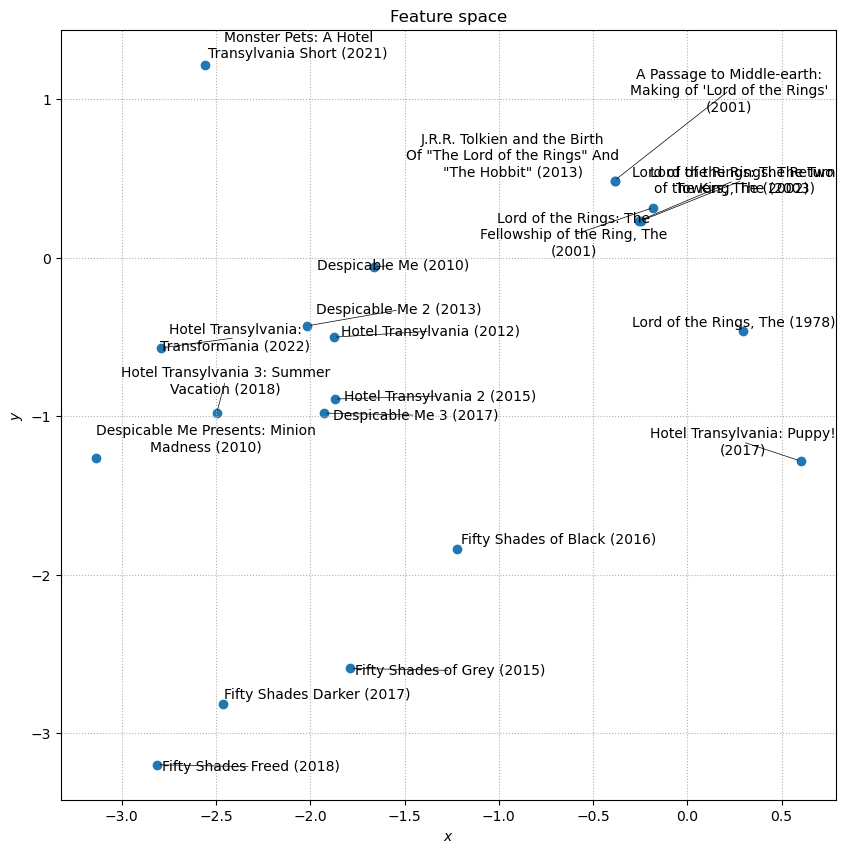

In [14]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_choice, 0], movie_embeddings_2d[movie_choice, 1])

texts = []
for i in movie_choice:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_movie_embedd_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Feature Embedding Space

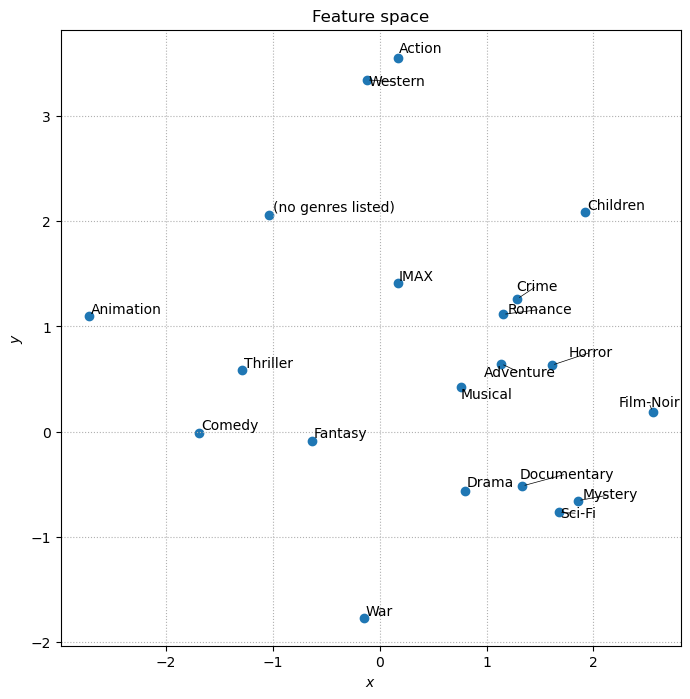

In [15]:
plt.subplots(figsize=(8, 8))

plt.scatter(feat_embeddings_2d[:,0], feat_embeddings_2d[:,1])

texts = []
for i, x in enumerate(feat_embeddings_2d):
    texts.append(plt.annotate(idx_to_feat_id[i], x))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_feature_2_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Dummy User Embedding

In [76]:
lord_of_the_ring_idx = movie_id_to_idx[title_to_movie_id["Lord of the Rings: The Fellowship of the Ring, The (2001)"]]
lord_of_the_ring_rating = 5.0

dummy_id = "dummy"
dummy_idx = len(user_id_to_idx)
user_id_to_idx[dummy_id] = dummy_idx
idx_to_user_id.append(dummy_id)

user_movie.append((
    [lord_of_the_ring_idx], [lord_of_the_ring_rating]
))

movie_user[lord_of_the_ring_idx][0].append(dummy_idx)
movie_user[lord_of_the_ring_idx][1].append(lord_of_the_ring_rating)

user_embeddings = np.vstack([user_embeddings, np.random.normal(0, np.sqrt(user_embeddings.shape[1]), (user_embeddings.shape[1]))])
user_bias = np.hstack([user_bias, np.random.randn()])

user_embeddings_with_f = np.vstack([user_embeddings_with_f, np.random.normal(0, np.sqrt(user_embeddings_with_f.shape[1]), (user_embeddings_with_f.shape[1]))])
user_bias_with_f = np.hstack([user_bias_with_f, np.random.randn()])

assert len(user_embeddings) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_bias) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_embeddings_with_f) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_bias_with_f) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"

In [77]:
for i in range(len(user_movie)):
    user_movie[i] = (
        np.array(user_movie[i][0], dtype=int),
        np.array(user_movie[i][1], dtype=np.float64),
    )

for i in range(len(movie_user)):
    movie_user[i] = (
        np.array(movie_user[i][0], dtype=int),
        np.array(movie_user[i][1], dtype=np.float64),
    )

In [78]:
old_embedding = user_embeddings[dummy_idx].copy()

for _ in range(5):
    optimize_users(
        [user_movie[dummy_idx]],
        user_embeddings.shape[1],
        r_lambda,
        r_gamma,
        r_tau,
        user_bias,
        movie_bias,
        user_embeddings[dummy_idx, np.newaxis],
        movie_embeddings
    )

assert ((old_embedding - user_embeddings[dummy_idx]) > 1e-2).any(), "Embedding not updated"

In [79]:
old_embedding = user_embeddings_with_f[dummy_idx].copy()

for _ in range(5):
    optimize_users(
        [user_movie[dummy_idx]],
        user_embeddings_with_f.shape[1],
        r_lambda,
        r_gamma,
        r_tau,
        user_bias_with_f,
        movie_bias_with_f,
        user_embeddings_with_f[dummy_idx, np.newaxis],
        movie_embeddings_with_f
    )

assert ((old_embedding - user_embeddings_with_f[dummy_idx]) > 1e-2).any(), "Embedding not updated"

#### Top 10 Prediction for Dummy User

In [80]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Top 10 Prediction
1 - Vinaro Bhagyamu Vishnu Katha (2023)  - degree: 1
2 - The Worker's Settlement (1966)  - degree: 1
3 - A Man in Love (1987)  - degree: 1
4 - Art of the Devil 3 (2008)  - degree: 1
5 - Homeroom (2021)  - degree: 1
6 - The Downfall of Santa Claus (2018)  - degree: 1
7 - Angkor Awakens: A Portrait of Cambodia (2017)  - degree: 1
8 - Kill Zone (1993)  - degree: 1
9 - Something Organic (1998)  - degree: 1
10 - Wall Of Secrets (2003)  - degree: 1


In [81]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Top 10 Prediction [downplayed bias]
1 - Homeroom (2021)  - degree: 1
2 - Little Red Riding Hood (1959)  - degree: 1
3 - The Downfall of Santa Claus (2018)  - degree: 1
4 - Angkor Awakens: A Portrait of Cambodia (2017)  - degree: 1
5 - Trick or Treat (2019)  - degree: 1
6 - Toyen: The Subversive Baroness Of Surrealism (2022)  - degree: 1
7 - Kill Zone (1993)  - degree: 1
8 - Naruto Shippuden the Movie: Road to Ninja (2012)  - degree: 69
9 - Wall Of Secrets (2003)  - degree: 1
10 - A Gay Girl in Damascus: The Amina Profile (2015)  - degree: 1


In [82]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>500 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>500 rating only)]
1 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449
2 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463
3 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73123
4 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616
5 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175
6 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149
7 - Avengers: Infinity War - Part II (2019)  - degree: 11811
8 - Harry Potter and the Deathly Hallows: Part 1 (2010)  - degree: 20969
9 - Aquaman (2018)  - degree: 2600
10 - Harry Potter and the Deathly Hallows: Part 2 (2011)  - degree: 20227


#### Top 10 Prediction for Dummy User [with features]

In [85]:
movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Top 10 Prediction
1 - Bingo Crosbyana (1936)  - degree: 1
2 - A Parting Shot (2007)  - degree: 2
3 - Dognapped (2014)  - degree: 1
4 - Acrimonius Alfie Atkins (2021)  - degree: 1
5 - Mr. Happy (2012)  - degree: 1
6 - Jade Tiger (1977)  - degree: 1
7 - Vinaro Bhagyamu Vishnu Katha (2023)  - degree: 1
8 - The Mountain II (2016)  - degree: 28
9 - Paul's Promise (2022)  - degree: 1
10 - Prince Harming (2019)  - degree: 1


In [83]:
movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Top 10 Prediction [downplayed bias]
1 - Bingo Crosbyana (1936)  - degree: 1
2 - A Parting Shot (2007)  - degree: 2
3 - Dognapped (2014)  - degree: 1
4 - Acrimonius Alfie Atkins (2021)  - degree: 1
5 - Mr. Happy (2012)  - degree: 1
6 - Jade Tiger (1977)  - degree: 1
7 - Prince Harming (2019)  - degree: 1
8 - The Mountain II (2016)  - degree: 28
9 - Paul's Promise (2022)  - degree: 1
10 - Barbra: The Music ... The Mem'ries ... The Magic! (2017)  - degree: 1


In [84]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>500 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>500 rating only)]
1 - Southland Tales (2006)  - degree: 642
2 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449
3 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463
4 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73123
5 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616
6 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175
7 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149
8 - Nacho Libre (2006)  - degree: 2805
9 - New World, The (2005)  - degree: 1344
10 - What the #$*! Do We Know!? (a.k.a. What the Bleep Do We Know!?) (2004)  - degree: 729


#### Top Polarizing Movies

In [53]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm")

for i, idx in enumerate(reversed(movie_embedding_norm[-20:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Top 20 Movie by embedding norm
1 - A Florida Enchantment (1914)  - degree: 2
2 - The Gangster (2012)  - degree: 1
3 - Glen or Glenda (1953)  - degree: 418
4 - Demon Hunter Makaryūdo (1989)  - degree: 1
5 - That's Cunning! Shijo Saidai no Sakusen? (1996)  - degree: 1
6 - Telling Lies (2006)  - degree: 1
7 - Mister Happiness (2017)  - degree: 1
8 - Plan 9 from Outer Space (1959)  - degree: 2521
9 - Drama (2018)  - degree: 2
10 - Od pełni do pełni (2012)  - degree: 1
11 - Necessary War, The (2014)  - degree: 1
12 - Frogs! (1991)  - degree: 1
13 - Warda (2014)  - degree: 1
14 - The Kill Room (2023)  - degree: 1
15 - A Dark Path (2020)  - degree: 1
16 - Bingo Crosbyana (1936)  - degree: 1
17 - What Lola Wants (2015)  - degree: 1
18 - Room, The (2003)  - degree: 1179
19 - Trumbull Land (2018)  - degree: 1
20 - Lost Boy (2015)  - degree: 2


In [61]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm [< 500 rating filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Top 20 Movie by embedding norm [< 500 rating filtering]
1 - Plan 9 from Outer Space (1959)  - degree: 2521
2 - Room, The (2003)  - degree: 1179
3 - Twilight Saga: Breaking Dawn - Part 2, The (2012)  - degree: 2362
4 - Twilight Saga: Breaking Dawn - Part 1, The (2011)  - degree: 2703
5 - What the #$*! Do We Know!? (a.k.a. What the Bleep Do We Know!?) (2004)  - degree: 729
6 - Twilight Saga: Eclipse, The (2010)  - degree: 4060
7 - Twilight Saga: New Moon, The (2009)  - degree: 4038
8 - Saw VI (2009)  - degree: 1443
9 - Twilight (2008)  - degree: 8882
10 - Saw VII 3D - The Final Chapter (2010)  - degree: 1094
11 - Saw IV (2007)  - degree: 2514
12 - Saw V (2008)  - degree: 1776
13 - Saw III (2006)  - degree: 3549
14 - Serbian Film, A (Srpski film) (2010)  - degree: 771
15 - Zeitgeist: The Movie (2007)  - degree: 940
16 - Adventures of Ford Fairlane, The (1990)  - degree: 667
17 - Saw (2004)  - degree: 12829
18 - Louis C.K.: Chewed Up (2008)  - degree: 1702
19 - Saw (2003)  - degree: 1634
2

In [69]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Top 20 Movie by embedding norm [cosine similarity filtering + < 500 rating filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break  
    if idx in filtering:
        continue
        
    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
        i += 1
        movie_bag.append(idx)

Top 20 Movie by embedding norm [cosine similarity filtering + < 500 rating filtering]
1 - Plan 9 from Outer Space (1959)  - degree: 2521
2 - Room, The (2003)  - degree: 1179
3 - Twilight Saga: Breaking Dawn - Part 2, The (2012)  - degree: 2362
4 - What the #$*! Do We Know!? (a.k.a. What the Bleep Do We Know!?) (2004)  - degree: 729
5 - Saw VI (2009)  - degree: 1443
6 - Serbian Film, A (Srpski film) (2010)  - degree: 771
7 - Zeitgeist: The Movie (2007)  - degree: 940
8 - Adventures of Ford Fairlane, The (1990)  - degree: 667
9 - Louis C.K.: Chewed Up (2008)  - degree: 1702
10 - Movie 43 (2013)  - degree: 844
11 - Birth of a Nation, The (1915)  - degree: 522
12 - Doom Generation, The (1995)  - degree: 800
13 - Cook the Thief His Wife & Her Lover, The (1989)  - degree: 3407
14 - Star Wars: The Rise of Skywalker (2019)  - degree: 3062
15 - Thor: Love and Thunder (2022)  - degree: 1095
16 - Pumpkin (2002)  - degree: 538
17 - Furious 7 (2015)  - degree: 3520
18 - Left Behind: The Movie (2000

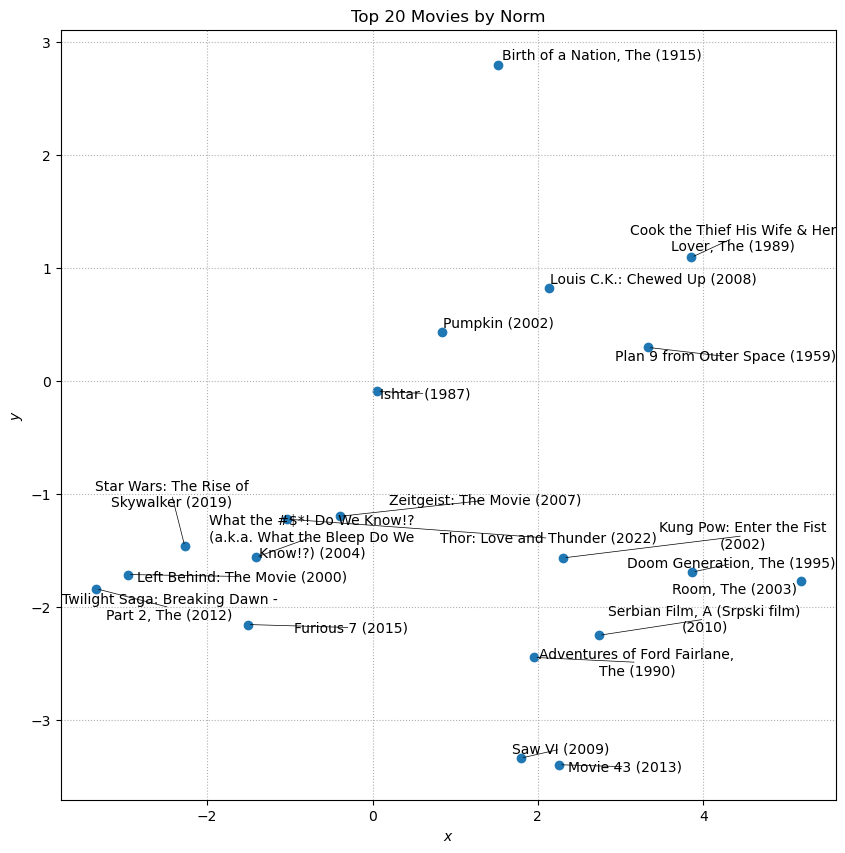

In [70]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Top 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/top_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Less Polarizing Movies

In [55]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Bottom 20 Movie by embedding norm")

for i, idx in enumerate(movie_embedding_norm[:20]):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Bottom 20 Movie by embedding norm
1 - Crime on a Summer Morning (1965)  - degree: 2
2 - The Americano (1955)  - degree: 1
3 - The Affairs of Martha (1942)  - degree: 1
4 - Murder at 45 R.P.M. (1960)  - degree: 2
5 - Don't Give Up the Ship (1959)  - degree: 2
6 - Orphans & Kingdoms (2014)  - degree: 2
7 - Slander (1957)  - degree: 1
8 - Nezha Conquers the Dragon King (1979)  - degree: 2
9 - La Vanité (2015)  - degree: 2
10 - Matthew Gray Gubler's Life Aquatic Intern Journal (2005)  - degree: 1
11 - Royally Wrapped For Christmas (2021)  - degree: 1
12 - The Bells of Death (1968)  - degree: 1
13 - Marry Go Round (2022)  - degree: 1
14 - Christmas Cookies (2016)  - degree: 1
15 - The Engagement Plot (2022)  - degree: 2
16 - With Love, Christmas (2017)  - degree: 2
17 - A Royal Corgi Christmas (2022)  - degree: 1
18 - A Winter Princess (2019)  - degree: 1
19 - Christmas Festival of Ice (2017)  - degree: 1
20 - Daughters Courageous (1939)  - degree: 1


In [65]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Bottom 20 Movie by embedding norm [< 500 rating filtering]")

i = 0
for idx in movie_embedding_norm:
    if i == 20:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Bottom 20 Movie by embedding norm [< 500 rating filtering]
1 - River Wild, The (1994)  - degree: 11536
2 - Backdraft (1991)  - degree: 8386
3 - Courage Under Fire (1996)  - degree: 8207
4 - Client, The (1994)  - degree: 16467
5 - White Squall (1996)  - degree: 4374
6 - That Thing You Do! (1996)  - degree: 8877
7 - Untouchables, The (1987)  - degree: 18929
8 - Stand by Me (1986)  - degree: 27367
9 - Walk the Line (2005)  - degree: 11478
10 - Catch Me If You Can (2002)  - degree: 38652
11 - Glory (1989)  - degree: 13152
12 - City Hall (1996)  - degree: 4154
13 - Bronx Tale, A (1993)  - degree: 5543
14 - Pleasantville (1998)  - degree: 15417
15 - Outbreak (1995)  - degree: 27883
16 - City Slickers II: The Legend of Curly's Gold (1994)  - degree: 13005
17 - Searching for Bobby Fischer (1993)  - degree: 11176
18 - Good Will Hunting (1997)  - degree: 50824
19 - October Sky (1999)  - degree: 8433
20 - Executive Decision (1996)  - degree: 12663


In [66]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 500
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Bottom 20 Movie by embedding norm [cosine similarity filtering + <500 ratings filtering]")

i = 0
for idx in movie_embedding_norm:
    if i == 20:
        break 
    if idx in filtering:
        continue

    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
        i += 1
        movie_bag.append(idx)

Bottom 20 Movie by embedding norm [cosine similarity filtering + <500 ratings filtering]
1 - River Wild, The (1994)  - degree: 11536
2 - Backdraft (1991)  - degree: 8386
3 - Client, The (1994)  - degree: 16467
4 - White Squall (1996)  - degree: 4374
5 - Untouchables, The (1987)  - degree: 18929
6 - Stand by Me (1986)  - degree: 27367
7 - Walk the Line (2005)  - degree: 11478
8 - Catch Me If You Can (2002)  - degree: 38652
9 - City Hall (1996)  - degree: 4154
10 - Bronx Tale, A (1993)  - degree: 5543
11 - Pleasantville (1998)  - degree: 15417
12 - City Slickers II: The Legend of Curly's Gold (1994)  - degree: 13005
13 - Searching for Bobby Fischer (1993)  - degree: 11176
14 - October Sky (1999)  - degree: 8433
15 - Few Good Men, A (1992)  - degree: 19616
16 - Mrs. Brown (a.k.a. Her Majesty, Mrs. Brown) (1997)  - degree: 2716
17 - The Count of Monte Cristo (2002)  - degree: 7844
18 - Wolf (1994)  - degree: 5679
19 - Almost Famous (2000)  - degree: 24024
20 - Erin Brockovich (2000)  - deg

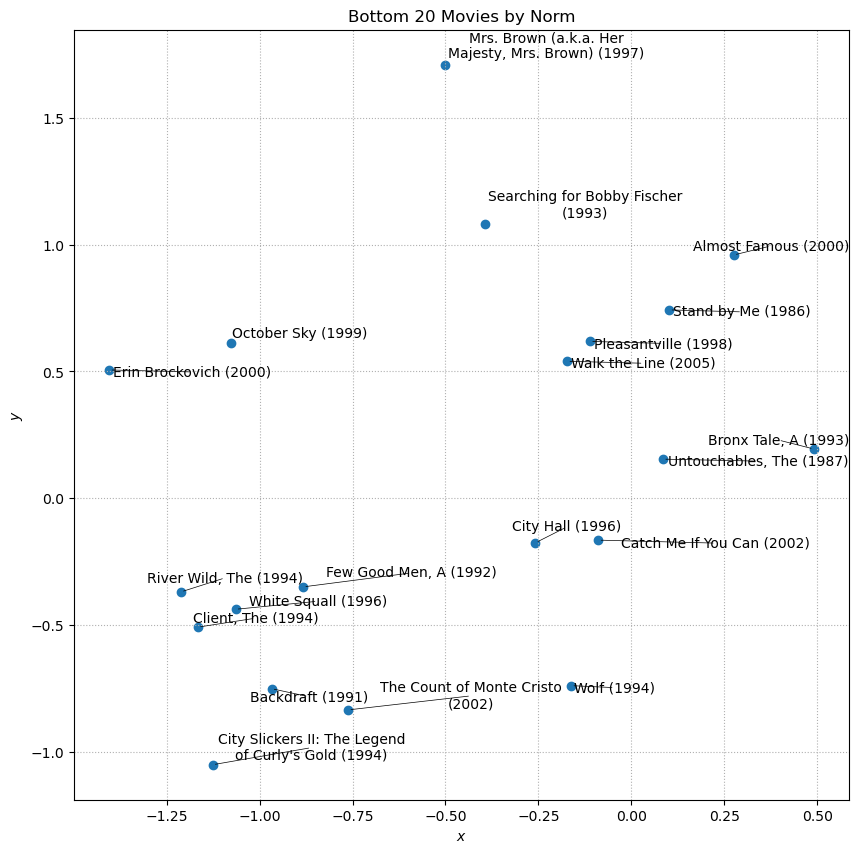

In [68]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Bottom 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/bottom_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

---